# This tool uses automated EST(AAA) forecasting to predict future enrollment needs for a given number of semesters

In [1]:
# REQUIRED IMPORTS

import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
!pip install sktime
from sktime.forecasting.ets import AutoETS
# from sktime.forecasting.model_selection import temporal_train_test_split # Not strictly needed for just forecasting
# from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError # Not strictly needed for just forecasting
import matplotlib.pyplot as plt
import numpy as np

## USER SPECIFICATIONS: Update (1) File path (csv), (2) Desired number of semesters to forecast

In [ ]:
# USER SPECIFICATIONS

### Configuration:

### --- ENTER FILE NAME BELOW 'File.csv' ----------------------------------------------------------------###
FILE_PATH = 'EnrollmentsRR.csv'
### -----------------------------------------------------------------------------------------------------###

### --- ENTER DESIRED NUMBER OF SEMESTERS TO BE FORECASTED ----------------------------------------------###
N_FORECAST_SEMESTERS = 3
### -----------------------------------------------------------------------------------------------------###

### --- ENTER ALL SEMESTERS TO BE ANALYZED IN TIME ORDER (e.g. 'WI23','SP23','FA23','WI24', etc. etc. ---###
SEMESTER_ORDER = [
    'WI16', 'SP16', 'FA16',
    'WI17', 'SP17', 'FA17',
    'WI18', 'SP18', 'FA18',
    'WI19', 'SP19', 'FA19'
]
### -----------------------------------------------------------------------------------------------------###

Original Data Head (before semester fill):
  Semester   Class  Section  Enrollment
0     FA16  ENG101        1          38
1      NaN  ENG101        2          40
2      NaN  ENG101        3          40
3     FA17  ENG101        1          27
4      NaN  ENG101        2          31

Original Data Info (before semester fill):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Semester    24 non-null     object
 1   Class       72 non-null     object
 2   Section     72 non-null     int64 
 3   Enrollment  72 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ KB

--- Columns detected by Pandas (after stripping whitespace) ---
['Semester', 'Class', 'Section', 'Enrollment']
---------------------------------------------------------------

Data Head (after semester forward fill):
  Semester   Class  Section  Enrollment
0     FA16  ENG101     

C:\Users\oliver20\AppData\Local\Temp\ipykernel_16916\58846071.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Semester'].fillna(method='ffill', inplace=True)
C:\Users\oliver20\AppData\Local\Temp\ipykernel_16916\58846071.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Semester'].fillna(method='ffill', inplace=True)


Generating forecast for 3 semesters for ENG101...

Forecast for ENG101 (next 3 semesters):
Future_Semester_Index_12   82.87
Future_Semester_Index_13   82.87
Future_Semester_Index_14   82.87
Name: Enrollment, dtype: float64
--------------------------------------------------


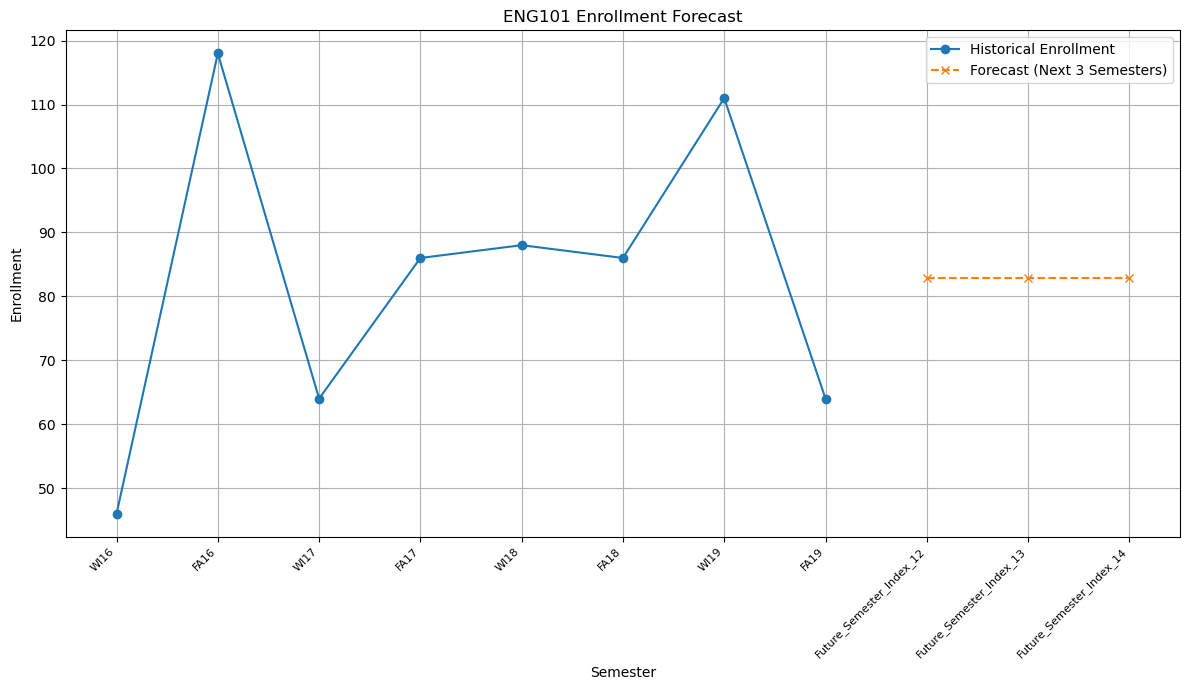


Processing Class: ENG102
Data for ENG102 (time series format - internal index):
0     28
1     19
2    118
3     36
4     34
Name: Enrollment, dtype: int64
Automating ETS for ENG102...
Generating forecast for 3 semesters for ENG102...

Forecast for ENG102 (next 3 semesters):
Future_Semester_Index_12   75.62
Future_Semester_Index_13   80.06
Future_Semester_Index_14   82.62
Name: Enrollment, dtype: float64
--------------------------------------------------


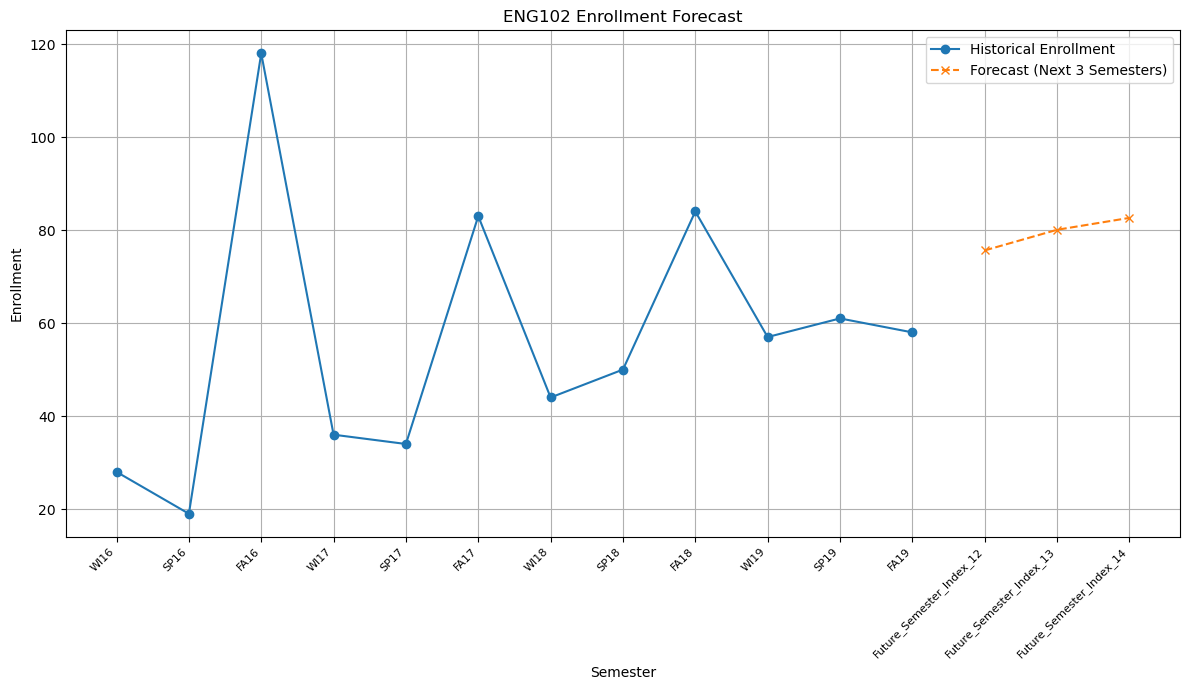


--- Summary of All Forecasts ---

Class: ENG101
Future_Semester_Index_12   82.87
Future_Semester_Index_13   82.87
Future_Semester_Index_14   82.87
Name: Enrollment, dtype: float64

Class: ENG102
Future_Semester_Index_12   75.62
Future_Semester_Index_13   80.06
Future_Semester_Index_14   82.62
Name: Enrollment, dtype: float64


In [4]:
# FORECAST TOOL

# --- 1. Load Data from CSV ---
try:
    df = pd.read_csv(FILE_PATH)
    
    # --- Clean Column Names ---
    df.columns = df.columns.str.strip() 
    # -----------------------------------------------

    print("Original Data Head (before semester fill):")
    print(df.head())
    print("\nOriginal Data Info (before semester fill):")
    df.info()
    print("\n--- Columns detected by Pandas (after stripping whitespace) ---")
    print(df.columns.tolist()) 
    print("---------------------------------------------------------------")
    
except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found. Please ensure it's in the same directory as the script.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    exit()

# --- 2. Data Cleaning and Preparation ---

df['Enrollment'] = pd.to_numeric(df['Enrollment'], errors='coerce')
df.dropna(subset=['Enrollment'], inplace=True) 

# --- IMPORTANT FIX: Forward fill missing Semester values ---
df['Semester'].fillna(method='ffill', inplace=True)
print("\nData Head (after semester forward fill):")
print(df.head())
print("-" * 30)
# ---------------------------------------------------------

# Create a unique time index for each semester based on the custom order
semester_to_int = {semester: i for i, semester in enumerate(SEMESTER_ORDER)}

# Map semesters to their integer order
df['Semester_Order'] = df['Semester'].map(semester_to_int)

# Remove any rows where Semester could not be mapped 
df.dropna(subset=['Semester_Order'], inplace=True)
df['Semester_Order'] = df['Semester_Order'].astype(int) 

# Sort the DataFrame by 'Class' and then by the new 'Semester_Order'
df_sorted = df.sort_values(by=['Class', 'Semester_Order'])

# --- 3. Separate into Tables by Class and Process ---
class_tables = {}
forecast_results = {}
ets_models = {}

for class_name in df_sorted['Class'].unique():
    print(f"\nProcessing Class: {class_name}")

    # Filter data for the current class
    class_df = df_sorted[df_sorted['Class'] == class_name].copy()

    # Aggregate Enrollment by Semester
    class_ts_data = class_df.groupby('Semester_Order')['Enrollment'].sum().sort_index()

    # Store the actual Semester_Order values for later mapping/display
    original_semester_orders_for_this_class_data = class_ts_data.index.tolist()

    # Create the time series 'y' with a default pd.RangeIndex (0, 1, 2, ...)
    y = pd.Series(class_ts_data.values, name='Enrollment')

    class_tables[class_name] = y
    print(f"Data for {class_name} (time series format - internal index):\n{y.head()}")

    # --- Automate ETS (AAA) ---
    print(f"Automating ETS for {class_name}...")

    seasonality_period = 3 
    forecaster = AutoETS(sp=seasonality_period, n_jobs=-1, auto=True)

    if len(y) < 2 * seasonality_period:
        print(f"Warning: Not enough data ({len(y)} points) for {class_name} to fit a seasonal model with sp={seasonality_period}. "
              "Falling back to non-seasonal ETS or simpler model (sp=1).")
        forecaster = AutoETS(sp=1, n_jobs=-1, auto=True) 
    
    forecaster.fit(y)
    ets_models[class_name] = forecaster

    # --- Print Forecast for the next N_FORECAST_SEMESTERS ---
    print(f"Generating forecast for {N_FORECAST_SEMESTERS} semesters for {class_name}...")

    last_relative_index_of_historical_data = len(y) - 1
    fh_start_relative = last_relative_index_of_historical_data + 1
    fh_end_relative = last_relative_index_of_historical_data + N_FORECAST_SEMESTERS
    forecasting_horizon_relative_indices = np.arange(fh_start_relative, fh_end_relative + 1)

    y_pred_relative_index = forecaster.predict(fh=forecasting_horizon_relative_indices)

    predicted_original_semester_orders = []
    current_original_semester_order_for_forecast = original_semester_orders_for_this_class_data[-1] + 1
    
    for _ in forecasting_horizon_relative_indices:
        predicted_original_semester_orders.append(current_original_semester_order_for_forecast)
        current_original_semester_order_for_forecast += 1 
    
    int_to_semester = {i: semester for i, semester in enumerate(SEMESTER_ORDER)}
    forecast_semester_names = [int_to_semester.get(idx, f"Future_Semester_Index_{idx}") for idx in predicted_original_semester_orders]

    y_pred_relative_index.index = forecast_semester_names 
    forecast_results[class_name] = y_pred_relative_index
    
    print(f"\nForecast for {class_name} (next {N_FORECAST_SEMESTERS} semesters):")
    print(y_pred_relative_index)
    print("-" * 50)

    # Optional: Plot the historical data and forecast
    plt.figure(figsize=(12, 7))
    
    historical_plot_semester_names = [int_to_semester.get(original_semester_orders_for_this_class_data[idx], str(original_semester_orders_for_this_class_data[idx])) for idx in y.index]
    
    plt.plot(historical_plot_semester_names, y.values, label='Historical Enrollment', marker='o')
    plt.plot(y_pred_relative_index.index, y_pred_relative_index.values, label=f'Forecast (Next {N_FORECAST_SEMESTERS} Semesters)', linestyle='--', marker='x')
    
    plt.title(f'{class_name} Enrollment Forecast')
    plt.xlabel('Semester')
    plt.ylabel('Enrollment')
    
    all_semesters_for_plot = historical_plot_semester_names + list(y_pred_relative_index.index)
    if len(all_semesters_for_plot) > 10: 
        plt.xticks(rotation=45, ha='right', fontsize=8)
    else:
        plt.xticks(rotation=0) 

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n--- Summary of All Forecasts ---")
for class_name, forecast in forecast_results.items():
    print(f"\nClass: {class_name}")
    print(forecast)